In [1]:
# In this Notebook I will make a predictive model for League of Legends games, to predict the games at different stages of the games' completion.  Before the game starts, after the champions are selected, and then at 10, 15, 20 and 25 minutes.  I will use logistic regression, along with other predictive ML models, on both stats from the data set as well as the elo ratings I created in LoL_Elo_System to incorporate the teams and champions selected into the predictions
# The first part of this notebook is focused on dataset creation.
# The second part is focused on regression models including gradient boost, logistic regression (with and without pca and transformation), and random forest classification

What hath God wrought


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
# I am not using sklearn.metrics.mean_squared_error because what I am predicting a binary result and so I will use accuracy score, F1 Score and the AUC_ROC score.  Whilst the F1 and AUC_ROC are generally more useful when there is a large imbalance in count between the 2 outcomes of the model, they will still be useful in identifying where the model is doing best.

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#elo_record_df = pd.read_pickle("elolol.pkl")
dflol = pd.read_pickle("dflol.pkl")

In [4]:
# Feature selection, I am only interested in timed statistics
dflol = dflol.drop(labels=["datacompleteness", "url", "league", "year", "split", "playoffs", "date", "game", "patch", "playername", "playerid", "teamname", "teamid", "ban1", "ban2", "ban3", "ban4", "ban5", "pick1", "pick2", "pick3", "pick4", "pick5", "gamelength", "teamkills", "teamdeaths", "chemtechs", "hextechs", "dragons (type unknown)", "void_grubs", "opp_void_grubs", "turretplates", "opp_turretplates", "elementaldrakes", "opp_elementaldrakes", "monsterkillsownjungle", "monsterkillsenemyjungle", "participantid", "firstdragon", "dragons", "opp_dragons", "infernals", "mountains", "clouds", "oceans", "elders", "opp_elders", "firstherald", "heralds", "opp_heralds", "firstbaron", "barons", "opp_barons", "firsttower", "towers", "opp_towers", "firstmidtower", "firsttothreetowers", "gspd", "gpr", "team kpm", "ckpm", "kills", "deaths", "assists", "doublekills", "triplekills", "quadrakills", "pentakills", "firstblood", "firstbloodkill", "firstbloodassist", "firstbloodvictim", "inhibitors", "opp_inhibitors", "damagetochampions", "dpm", "damageshare", "damagetakenperminute", "damagemitigatedperminute", "wardsplaced", "wpm", "wardskilled", "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm", "earnedgoldshare", "goldspent", "total cs", "minionkills", "monsterkills", "cspm"],
            axis=1)

In [5]:
# Create derivative columns and drop columns that are mirrored, like opponent stats.  These stats are duplicated because one team's opponent deaths is going to be identical to the other team's actual deaths.
for time in ["10","15","20","25"]:
    dflol[f"killparticipationsat{time}"] = dflol[f"killsat{time}"] + dflol[f"assistsat{time}"]
    dflol[f"opp_killparticipationsat{time}"] = dflol[f"opp_killsat{time}"] + dflol[f"opp_assistsat{time}"]
    dflol[f"killparticipationsdiffat{time}"] = dflol[f"killparticipationsat{time}"] - dflol[f"opp_killparticipationsat{time}"]
    dflol[f"killdiffat{time}"] = dflol[f"killsat{time}"] - dflol[f"opp_killsat{time}"]
    dflol = dflol.drop([f"opp_goldat{time}", f"opp_xpat{time}", f"opp_csat{time}", f"opp_killsat{time}", f"opp_assistsat{time}", f"opp_deathsat{time}", f"opp_killparticipationsat{time}"], axis=1)

In [6]:
# This dataframe removes all rows that include team stats rather than player stats.  This will be used for adjusted stats in due course
dflol_no_teams = dflol.dropna()

# Drop the "champion" column and NaN values.  Set the index in preparation for dataset creation
dflol = dflol.drop("champion", axis=1).dropna().set_index(["gameid", "side"])

In [7]:
# Create 6 dataframes for the 5 positions plus the team stats
# Like in the previous notebooks, I am reducing the number of rows and increasing the number of columns so that all of the relevant information for each game is on 1 row.
positions = ["top", "jng", "mid", "bot", "sup", "team"]
positions_list = []
for i in range(6):
    positions_list.append(dflol[dflol["position"] == positions[i]])

# Keep only 1 column with the result
# Add prefixes for all of the column names
for i in range(len(positions_list)):
    positions_list[i] = positions_list[i].drop("position", axis=1)
    if i > 0:
        positions_list[i] = positions_list[i].drop("result", axis=1)
    new_columns = []
    for c in positions_list[i].columns.to_list():
        c = positions[i] + "_" + c
        new_columns.append(c)
    positions_list[i].columns = new_columns

# Merge the 6 dataframes together
df_blue_red_stats = pd.concat([positions_list[0],
                              positions_list[1],
                              positions_list[2],
                              positions_list[3],
                              positions_list[4],
                              positions_list[5]],
                              axis=1)

In [8]:
# Change the index for the purposes of moving all the data from both red and blue teams onto the same row
df_blue_red_stats = df_blue_red_stats.reset_index().set_index("gameid")

# Split the data into 2, one dataframe for the team on blue side, the other for the team on red side
blue_df = df_blue_red_stats[df_blue_red_stats["side"] == "Blue"].drop("side",axis=1).add_prefix("blue_", axis=1)
red_df = df_blue_red_stats[df_blue_red_stats["side"] == "Red"].drop(["side", "top_result"], axis=1).add_prefix("red_", axis=1)
# Merge the 2 dataframes together so that each game occupies only a single row
stats_df = blue_df.merge(red_df, on="gameid").rename({"blue_top_result":"blue_result"}, axis=1)

In [9]:
stats_df.head()

,blue_result,blue_top_goldat10,blue_top_xpat10,blue_top_csat10,blue_top_golddiffat10,blue_top_xpdiffat10,blue_top_csdiffat10,blue_top_killsat10,blue_top_assistsat10,blue_top_deathsat10,...,red_team_killdiffat10,red_team_killparticipationsat15,red_team_killparticipationsdiffat15,red_team_killdiffat15,red_team_killparticipationsat20,red_team_killparticipationsdiffat20,red_team_killdiffat20,red_team_killparticipationsat25,red_team_killparticipationsdiffat25,red_team_killdiffat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,3080.0,3907.0,57.0,-6.0,-87.0,0.0,2.0,0.0,0.0,...,-1.0,6.0,-6.0,-2.0,10.0,-6.0,-2.0,10.0,-23.0,-6.0
TRLH3/44,1,3268.0,4433.0,83.0,69.0,97.0,1.0,1.0,0.0,1.0,...,1.0,12.0,6.0,2.0,17.0,-4.0,0.0,17.0,-6.0,-1.0
TRLH3/76,0,2912.0,4257.0,72.0,-188.0,-311.0,-8.0,0.0,0.0,1.0,...,1.0,6.0,1.0,0.0,7.0,2.0,1.0,11.0,4.0,1.0
TRLH3/85,1,2990.0,4699.0,86.0,-237.0,0.0,-4.0,0.0,0.0,0.0,...,-1.0,2.0,-4.0,-3.0,13.0,-14.0,-6.0,16.0,-38.0,-12.0
TRLH3/10072,0,2404.0,3087.0,46.0,-438.0,-893.0,-23.0,0.0,0.0,0.0,...,0.0,6.0,5.0,2.0,10.0,9.0,4.0,18.0,17.0,7.0


In [10]:
# Drop the result column, as it will be identical to the "blue_result" column already in the stats_df dataframe
dflol_no_teams = dflol_no_teams.drop("result", axis=1)

In [11]:
# Compared to dflol above, dflol_no_teams contains the name of each champion.  This is for standardising the in-game statistics for each champion.
dflol_no_teams.head()

,gameid,side,position,champion,goldat10,xpat10,csat10,golddiffat10,xpdiffat10,csdiffat10,...,killdiffat10,killparticipationsat15,killparticipationsdiffat15,killdiffat15,killparticipationsat20,killparticipationsdiffat20,killdiffat20,killparticipationsat25,killparticipationsdiffat25,killdiffat25
0,TRLH3/33,Blue,top,Trundle,3080.0,3907.0,57.0,-6.0,-87.0,0.0,...,1.0,2.0,0.0,1.0,3.0,0.0,2.0,7.0,4.0,2.0
1,TRLH3/33,Blue,jng,Vi,2335.0,2732.0,32.0,-1102.0,-1425.0,-27.0,...,-2.0,2.0,0.0,-2.0,3.0,0.0,-2.0,5.0,2.0,-2.0
2,TRLH3/33,Blue,mid,Orianna,2817.0,4216.0,73.0,-325.0,-87.0,5.0,...,0.0,1.0,-1.0,0.0,2.0,-1.0,-1.0,6.0,3.0,0.0
3,TRLH3/33,Blue,bot,Jinx,3487.0,3259.0,78.0,977.0,840.0,27.0,...,2.0,3.0,3.0,3.0,4.0,4.0,3.0,8.0,8.0,6.0
4,TRLH3/33,Blue,sup,Annie,2132.0,3079.0,5.0,337.0,296.0,-9.0,...,0.0,4.0,4.0,0.0,4.0,3.0,0.0,7.0,6.0,0.0


In [12]:
#Gather the list of stats and determine how many there are
list_of_column_stats = dflol_no_teams.columns[4:]

# 2 dataframes for the mean and standard deviation of each champion per role
mean_df = dflol_no_teams.groupby(["champion", "position"])[list_of_column_stats].mean().dropna()
std_df = dflol_no_teams.groupby(["champion", "position"])[list_of_column_stats].std().dropna()

In [13]:
# We can see that for each champion's position, we can see their mean statistics
mean_df.head(10)

goldat10       xpat10     csat10  golddiffat10  \
champion position                                                      
Aatrox   bot       3237.500000  4062.000000  63.500000    234.000000   
         jng       3250.504505  3380.342342  57.418919     10.698198   
         mid       3348.270000  4660.512000  80.650000     14.092000   
         sup       2969.333333  4187.666667  64.000000    838.000000   
         top       3224.064512  4609.365828  76.460967    -24.947739   
Ahri     bot       3421.625000  3451.500000  78.250000      9.250000   
         jng       3749.000000  4836.000000  88.000000    330.000000   
         mid       3390.835682  4661.425904  84.277372    -16.223561   
         top       3333.777778  4743.777778  82.222222    201.555556   
Akali    bot       3508.000000  4926.333333  87.333333     -9.000000   

                    xpdiffat10  csdiffat10  killsat10  assistsat10  \
champion position                                                    
Aatrox   bot        950.000000   -0.500000   0.500000     1.000000   
         jng         51.806306    1.504505   0.481982     0.545045   
         mid        103.092000   -0.434000   0.484000     0.452000   
         sup       1385.333333   53.000000   0.333333     0.333333   
         top         52.447152    0.433338   0.331813     0.304835   
Ahri     bot        306.125000   -4.125000   0.750000     0.750000   
         jng        844.000000   16.000000   1.000000     0.000000   
         mid         -7.922424   -1.378204   0.467493     0.513156   
         top        113.666667    9.777778   0.333333     0.444444   
Akali    bot       1505.000000   10.666667   0.666667     0.000000   

                   deathsat10     goldat15  ...  killdiffat10  \
champion position                           ...                 
Aatrox   bot         0.000000  4757.500000  ...      0.000000   
         jng         0.270270  5041.779279  ...     -0.004505   
         mid         0.340000  5365.688000  ...      0.090000   
         sup         0.666667  4805.666667  ...      0.000000   
         top         0.440115  5182.507624  ...     -0.008732   
Ahri     bot         0.875000  5456.000000  ...      0.000000   
         jng         0.000000  6315.000000  ...      0.000000   
         mid         0.308267  5428.932439  ...      0.045833   
         top         0.222222  5310.333333  ...      0.222222   
Akali    bot         0.333333  5671.000000  ...     -0.333333   

                   killparticipationsat15  killparticipationsdiffat15  \
champion position                                                       
Aatrox   bot                     3.000000                    0.000000   
         jng                     2.121622                   -0.337838   
         mid                     2.002000                    0.188000   
         sup                     2.333333                   -0.333333   
         top                     1.411834                   -0.067379   
Ahri     bot                     2.500000                    0.125000   
         jng                     3.000000                    0.000000   
         mid                     2.146155                    0.307588   
         top                     1.777778                    1.222222   
Akali    bot                     2.000000                   -1.333333   

                   killdiffat15  killparticipationsat20  \
champion position                                         
Aatrox   bot          -1.000000                5.500000   
         jng           0.000000                3.193694   
         mid           0.094000                3.240000   
         sup          -0.333333                2.666667   
         top           0.040662                2.545028   
Ahri     bot           0.125000                4.000000   
         jng          -1.000000                6.000000   
         mid           0.107622                3.794602   
         top           0.222222                3.000000   
Akali    

In [14]:
# Combine mean and std dataframes with the dataframe holding the stastitics for each game
adjusted_stats_calc_df = (dflol_no_teams.merge(mean_df, on=["champion", "position"], suffixes=["", "_mean"]).merge(std_df, on=["champion", "position"], suffixes=["", "_std"]))
# Total number of stats to be standardised
len(list_of_column_stats)

48

In [15]:
# Isolate the mean and std rows within the dataframe
list_of_mean_column_stats = adjusted_stats_calc_df.columns[52:100]
list_of_std_column_stats = adjusted_stats_calc_df.columns[100:148]

# Standardise the statistics by taking away the mean and dividing by the standard deviation
for i in range(48):
    adjusted_stats_calc_df[list_of_column_stats[i]] = adjusted_stats_calc_df[list_of_column_stats[i]] - adjusted_stats_calc_df[list_of_mean_column_stats[i]]
    adjusted_stats_calc_df[list_of_column_stats[i]] = adjusted_stats_calc_df[list_of_column_stats[i]] / adjusted_stats_calc_df[list_of_std_column_stats[i]]
# Drop the columns that held the mean and standard deviation and set the index again
adjusted_stats_calc_df = adjusted_stats_calc_df.iloc[:,:52].drop("champion", axis=1).set_index(["gameid", "side"])

In [16]:
# Split the dataframe, as for the unadjusted stats, by position, into 5 dataframes for the purposes of combining the data into a single column
positions_list2 = []
for i in range(5):
    positions_list2.append(adjusted_stats_calc_df[adjusted_stats_calc_df["position"] == positions[i]])

# Rename the column titles
for i in range(len(positions_list2)):
    positions_list2[i] = positions_list2[i].drop("position", axis=1)
    new_columns = []
    for c in positions_list2[i].columns.to_list():
        c = positions[i] + "_" + c
        new_columns.append(c)
    positions_list2[i].columns = new_columns

# Merge the 5 dataframes together
df_blue_red_adjusted_stats = pd.concat([positions_list2[0],
                              positions_list2[1],
                              positions_list2[2],
                              positions_list2[3],
                              positions_list2[4]],
                              axis=1).reset_index().set_index("gameid")

In [17]:
# List of team stats to derive
raw_stats = dflol.columns[2:]



# Split the dataframes into red and blue
blue_adjusted_df = df_blue_red_adjusted_stats[df_blue_red_adjusted_stats["side"] == "Blue"].drop("side",axis=1)
red_adjusted_df = df_blue_red_adjusted_stats[df_blue_red_adjusted_stats["side"] == "Red"].drop("side",axis=1)

# List of positional stats to derive from
positional_stats = blue_adjusted_df.columns

# Create the derived team stats
for i in range(48):
   blue_adjusted_df[f"team_{raw_stats[i]}"] = (blue_adjusted_df[positional_stats[i]] +
                                                     blue_adjusted_df[positional_stats[i + 48]] +
                                                     blue_adjusted_df[positional_stats[i + 96]] +
                                                     blue_adjusted_df[positional_stats[i + 144]] +
                                                     blue_adjusted_df[positional_stats[i + 192]])/5
red_adjusted_df[f"team_{raw_stats[i]}"] = (red_adjusted_df[positional_stats[i]] +
                                                     red_adjusted_df[positional_stats[i + 48]] +
                                                     red_adjusted_df[positional_stats[i + 96]] +
                                                     red_adjusted_df[positional_stats[i + 144]] +
                                                     red_adjusted_df[positional_stats[i + 192]])/5
# Add a prefix for red teams
blue_adjusted_df = blue_adjusted_df.add_prefix("blue_")
red_adjusted_df = red_adjusted_df.add_prefix("red_")

# Combine the 2 dataframes together and add a prefix
adjusted_stats_df = (blue_adjusted_df.merge(red_adjusted_df, on="gameid")).add_prefix("adj_")

In [18]:
adjusted_stats_df.head()

,adj_blue_top_goldat10,adj_blue_top_xpat10,adj_blue_top_csat10,adj_blue_top_golddiffat10,adj_blue_top_xpdiffat10,adj_blue_top_csdiffat10,adj_blue_top_killsat10,adj_blue_top_assistsat10,adj_blue_top_deathsat10,adj_blue_top_goldat15,...,adj_red_sup_killparticipationsat15,adj_red_sup_killparticipationsdiffat15,adj_red_sup_killdiffat15,adj_red_sup_killparticipationsat20,adj_red_sup_killparticipationsdiffat20,adj_red_sup_killdiffat20,adj_red_sup_killparticipationsat25,adj_red_sup_killparticipationsdiffat25,adj_red_sup_killdiffat25,adj_red_team_killdiffat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,-0.135168,-0.021855,-0.520006,-0.132154,-0.151887,-0.166628,3.024814,-0.512389,-0.581798,-0.212773,...,-1.167364,-1.772280,0.003871,-1.002259,-1.004850,0.020241,-1.209262,-1.330699,0.029250,-0.514382
TRLH3/20057,-0.707841,0.982862,0.751272,-0.065393,0.725057,0.320334,-0.457858,-0.512389,-0.581798,-0.492693,...,-0.592974,-0.016656,-0.075485,-0.147945,0.611914,-0.123935,-0.023728,0.607632,0.610750,0.102524
TRLH3/20094,0.098575,0.628928,-0.022550,2.006275,1.603745,1.850784,-0.457858,2.779747,-0.581798,-0.071018,...,-1.167364,-0.517327,0.003871,-1.377511,-0.404050,0.020241,-1.476287,-0.311835,0.029250,-0.088843
TRLH3/20100,-2.069398,-0.391013,-1.238555,-1.304638,-0.913765,-1.766644,-0.457858,-0.512389,-0.581798,-0.826444,...,-0.049350,0.402716,1.033206,-0.147945,0.305087,0.776833,-0.581333,0.189292,0.610750,0.123333
TRLH3/20115,-0.368912,-0.531826,-0.630552,0.011799,-1.483865,-2.114473,1.283478,-0.512389,-0.581798,-0.076401,...,-0.049350,0.402716,1.033206,-0.147945,0.305087,0.776833,-0.302530,-0.229049,-0.167873,0.552098


In [19]:
# Merge the adjusted and unadjusted stats
stats_df = stats_df.merge(adjusted_stats_df, on="gameid")
# Drop all red_diff columns because they will be the exact negative of blue_diff columns
stats_df = stats_df[stats_df.columns.drop(list(stats_df.filter(regex="red.*?diff.*?")))]

In [20]:
# Read in the elo_record dataframe created in Notebook 2, Lol_Elo_SDystem.ipynb
elo_record_df = pd.read_pickle("elolol.pkl").drop("predict", axis=1)

# Drop all "id" columns and the "year" column
elo_record_df = elo_record_df[elo_record_df.columns.drop(list(elo_record_df.filter(regex="playerid|champion")))].drop("year", axis=1)

In [21]:
elo_record_df.head()

,side,win_top_player_elo,win_jng_player_elo,win_mid_player_elo,win_bot_player_elo,win_sup_player_elo,win_team_elo,win_top_champ_elo,win_jng_champ_elo,win_mid_champ_elo,...,lose_mid_player_elo,lose_bot_player_elo,lose_sup_player_elo,lose_team_elo,lose_top_champ_elo,lose_jng_champ_elo,lose_mid_champ_elo,lose_bot_champ_elo,lose_sup_champ_elo,lose_total_elo
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,37832.613112
TRLH3/44,1,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1502.423506,1500.000000,1500.000000,1497.622444,37832.543486
TRLH3/76,-1,1500.408248,1500.661153,1500.748857,1500.910457,1500.972418,1501.150509,1497.496981,1499.998781,1500.000000,...,1499.250766,1499.089085,1499.027093,1498.848912,1502.503019,1500.000000,1497.548244,1500.000000,1495.243692,37813.137657
TRLH3/85,1,1499.591752,1499.338847,1499.251143,1499.089543,1499.027582,1498.849491,1500.000000,1497.511385,1500.000000,...,1500.749234,1500.910915,1500.972907,1501.151088,1499.934047,1500.000000,1500.000000,1500.001367,1502.378752,37851.534587
TRLH3/10072,-1,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.065953,1502.487396,1497.549476,...,1500.000000,1500.000000,1500.000000,1500.000000,1497.144695,1500.213487,1502.516359,1496.970148,1502.441431,37832.912468


In [22]:
# The following code splits the dataframe from having the columns split into the winning and losing team, to the columns split into the blue side and red side teams.

# Split the dataframe into red and blue
elo_blue_df = elo_record_df[elo_record_df["side"] == 1]
elo_red_df = elo_record_df[elo_record_df["side"] == -1]

# Add changed column titles.  The elo_blue_df columns mean that blue side team won, for the elo_red_df columns, the red side team won
elo_blue_df.columns = elo_blue_df.columns.str.replace("win", "blue").str.replace("lose", "red")
elo_red_df.columns = elo_red_df.columns.str.replace("win", "red").str.replace("lose", "blue")

# Join the 2 dataframes back together
blue_red_elo_record_df = pd.concat([elo_blue_df, elo_red_df]).drop("side", axis=1)
# Add a new column for the difference between the total elo ratings of each team
blue_red_elo_record_df["elo_diff"] = blue_red_elo_record_df["blue_total_elo"] - blue_red_elo_record_df["red_total_elo"]

# Merge the elo_record with the statistics
stats_df = stats_df.merge(blue_red_elo_record_df, on="gameid").dropna()

In [23]:
stats_df.shape
# 909 features in the dataframe + 1 results column

(66436, 910)

In [24]:
# Split stats_df into train and test arrays
blue_result = stats_df["blue_result"]

array_train, array_test, result_train, result_test =train_test_split(
    stats_df.drop(labels=["blue_result"], axis=1), blue_result, test_size = 0.2, random_state=1)

In [25]:
# I will compare the machine learning models to the stat of who is leading in gold, kills or elo differential
# A full analysis of the different models will be conducted at the end of the notebook

times = ["0", "10", "15", "20", "25"]
results_df = pd.DataFrame(columns=["Model", "Time", "Test Accuracy", "F-1", "Train Accuracy"])
for stat in ["kill", "gold", "xp"]:
    for time in times[1:]:
        temp_series = array_test[f"blue_team_{stat}diffat{time}"] > 0
        accuracy_test = accuracy_score(result_test, temp_series)
        f1 = f1_score(result_test, temp_series)
        accuracy_train = accuracy_score(result_train, array_train[f"blue_team_{stat}diffat{time}"] > 0)
        results_df.loc[f"{stat}_diff_at{time}"] = [f"{stat}_diff", time, accuracy_test, f1, accuracy_train]

results_df.loc["elo_diff"] = ["elo_diff",
                              "0",
                              accuracy_score(result_test, array_test["elo_diff"]+ 23.27479618 > 0),
                              f1_score(result_test, array_test["elo_diff"]+ 23.27479618 > 0),
                              accuracy_score(result_train, array_train["elo_diff"]+ 23.27479618 > 0)]
results_df

,Model,Time,Test Accuracy,F-1,Train Accuracy
kill_diff_at10,kill_diff,10,0.618603,0.582124,0.622168
kill_diff_at15,kill_diff,15,0.675497,0.663125,0.677241
kill_diff_at20,kill_diff,20,0.734347,0.730122,0.729736
kill_diff_at25,kill_diff,25,0.795756,0.798005,0.793783
gold_diff_at10,gold_diff,10,0.670831,0.686766,0.674908
gold_diff_at15,gold_diff,15,0.721252,0.736894,0.727064
gold_diff_at20,gold_diff,20,0.775662,0.787147,0.773011
gold_diff_at25,gold_diff,25,0.833534,0.842383,0.833992
xp_diff_at10,xp_diff,10,0.641180,0.655442,0.649846
xp_diff_at15,xp_diff,15,0.700256,0.706550,0.701362


In [26]:
def logistic_regression(array_train, array_test, new_columns, info):

    # Scale data
    scaler = StandardScaler()
    array_train = scaler.fit_transform(array_train)
    array_test = scaler.transform(array_test)

    # Fit and test the regression model
    model = LogisticRegression(max_iter=100000, penalty="elasticnet", solver="saga", l1_ratio=0.5, C=0.01)
    model.fit(array_train, result_train)
    pred_result_test = model.predict(array_test)
    pred_result_train = model.predict(array_train)

    # Extract the w constants
    rank = pd.Series(model.coef_.flatten(), index=new_columns).sort_values(ascending=False)

    # Find the accuracy
    accuracy_test = accuracy_score(result_test, pred_result_test)
    f1 = f1_score(result_test, pred_result_test)
    accuracy_train = accuracy_score(result_train, pred_result_train)

    results_df.loc[f"{info}log_reg_at{time}"] = ["log_reg", time, accuracy_test, f1, accuracy_train]

    return (accuracy_test,
            f1,
            accuracy_train,
            rank)

def timed_logistic_regression(array_train, array_test, time="None", info=""):

    def timed_feature_selection(array_train, array_test, string, info):
        for c in array_train.columns:
            if "result" in c or "elo" in c or c[-2:] in string:
                new_columns.append(c)
        return logistic_regression(array_train[new_columns], array_test[new_columns], new_columns, info)

    new_columns = []

    if time == "10":
        return timed_feature_selection(array_train, array_test, "10", info)
    elif time == "15":
        return timed_feature_selection(array_train, array_test, "10 15", info)
    elif time == "20":
        return timed_feature_selection(array_train, array_test, "10 15 20", info)
    elif time == "25":
        return timed_feature_selection(array_train, array_test, "10 15 20 25", info)
    else:
        print("no valid time given.  Using only data available before the match")
        return timed_feature_selection(array_train, array_test, "None", info)

In [38]:
for time in times:
    test_accuracy, f1, train_accuracy, rank = timed_logistic_regression(array_train, array_test, time)
    print(test_accuracy, f1, train_accuracy, time)
# We can see that as the game gets longer, the accuracy of the predictions increase as well, with slightly larger increases in accuracy between 20 and 25 than the others.

no valid time given.  Using only data available before the match
0.6322245635159542 0.6654801834485591 0.6378414992097539 0
0.7057495484647802 0.7260369955156951 0.7125950176864605 10
0.742098133654425 0.7566223989773453 0.7545156920298036 15
0.7928205900060205 0.803286888174348 0.7941973357417024 20
0.8461770018061409 0.854498861047836 0.8465041017535937 25


In [39]:
print("gold:", rank.loc[rank.index.str.contains("gold")].abs().sum())
print("elo:",rank[rank.index.str.contains("elo")].abs().sum())
print("kills:",rank[rank.index.str.contains("kill")].abs().sum())
print("xp:",rank[rank.index.str.contains("xp")].abs().sum())
print("cs:",rank[rank.index.str.contains("cs")].abs().sum())

gold: 2.2345791852950008
elo: 0.6201579644839669
kills: 0.8925925771309378
xp: 1.1097030011847768
cs: 0.6706107200147561


In [40]:
from sklearn.decomposition import PCA
def pca_logistic_regression(array_train, array_test, info):

    # Scale data
    scaler = StandardScaler()
    array_train = scaler.fit_transform(array_train)
    array_test = scaler.transform(array_test)

    # Apply PCA
    pca = PCA(n_components=array_train.shape[1])
    reduced_array_train = pca.fit_transform(array_train)
    reduced_array_test = pca.transform(array_test)

    # Maintain 95% of the data of the original dataframe
    percent95_of_data = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>0.95).min()
    reduced_array_train = reduced_array_train[:,:percent95_of_data]
    reduced_array_test = reduced_array_test[:,:percent95_of_data]

    # Apply logistic regression
    model = LogisticRegression(max_iter=100000, penalty="elasticnet", solver="saga", l1_ratio=0.5, C=0.01)
    model.fit(reduced_array_train, result_train)
    pred_result_test = model.predict(reduced_array_test)
    pred_result_train = model.predict(reduced_array_train)

    # Find the accuracy
    accuracy_test = accuracy_score(result_test, pred_result_test)
    f1 = f1_score(result_test, pred_result_test)
    accuracy_train = accuracy_score(result_train, pred_result_train)

    results_df.loc[f"{info}pca_log_reg_at{time}"] = ["pca_log_reg", time, accuracy_test, f1, accuracy_train]
    return (accuracy_test,
            f1,
            accuracy_train)

def timed_pca_logistic_regression(array_train, array_test, time="None", info=""):

    def timed_pca_feature_selection(array_train, array_test, string, info):
        for c in array_train.columns:
            if "result" in c or "elo" in c or c[-2:] in string:
                new_columns.append(c)
        return pca_logistic_regression(array_train[new_columns], array_test[new_columns],
                                   info)

    new_columns = []

    if time == "10":
        return timed_pca_feature_selection(array_train, array_test, "10", info)
    elif time == "15":
        return timed_pca_feature_selection(array_train, array_test, "10 15", info)
    elif time == "20":
        return timed_pca_feature_selection(array_train, array_test, "10 15 20", info)
    elif time == "25":
        return timed_pca_feature_selection(array_train, array_test, "10 15 20 25", info)
    else:
        print("no valid time given.  Using only data available before the match")
        return timed_pca_feature_selection(array_train, array_test, "None", info)

In [41]:
for time in times:
    test_accuracy, f1, train_accuracy = timed_pca_logistic_regression(array_train, array_test, time)
    print(test_accuracy, f1, train_accuracy, time)
# Comparable to the non-PCA results.  But the time to compute is much shorter

no valid time given.  Using only data available before the match
0.6296658639373871 0.6638890786148487 0.638612929931512 0
0.7049217338952438 0.7251314405888538 0.7129713253556107 10
0.7427754364840458 0.7575886524822696 0.7542334612779409 15
0.7884557495484648 0.7994578012413498 0.7914314743734477 20
0.8429409993979531 0.8510881198715662 0.84486716339279 25


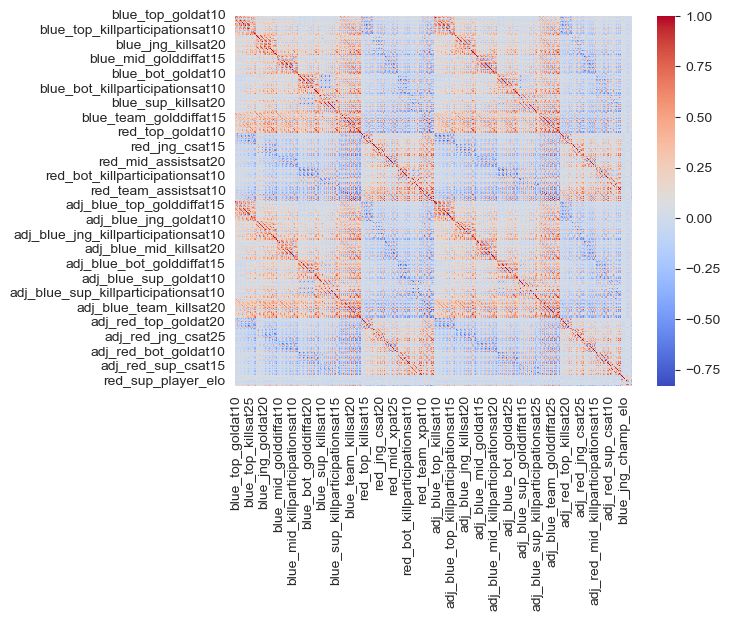

In [29]:
# Feature reduction.  I will engage in feature transformation first and then PCA, (principal component analysis).
# Based on my knowledge of the data through the exploratory data analysis, it is highly unlikely that any polynomial transformation (larger than x^3) will be of any value.
stats_corr = pd.concat([array_train, result_train], axis=1).corr()
plt.figure()
sns.heatmap(stats_corr, cmap="coolwarm")
plt.show()

In [30]:
# Get rid of duplicate values by creating a triangular matrix
correlation = stats_corr.where(np.triu(np.ones(stats_corr.shape), k=1).astype(bool)).stack().reset_index()
correlation.columns = ["feature_1", "feature_2", "R^2"]
# Find the correlation with winning of the statistics
blue_result_corr = correlation[correlation["feature_2"] == "blue_result"].drop("feature_2", axis=1).rename({"feature_1":"feature", "R^2":"R^2"}, axis=1).set_index("feature")#.squeeze().sort_values()

In [31]:
# The least correlated statistics for winning are the cs of the Sup role, which generally doesn't kill minions and so having a higher cs won't be correlated to winning
# Also of note is the champion elo ratings which are not correlated strongly to winning
blue_result_corr[blue_result_corr["R^2"].abs() < 0.1]

,R^2
feature,
blue_top_xpat10,0.082164
blue_top_csat10,0.078526
blue_top_killsat10,0.083680
blue_top_assistsat10,0.086363
blue_top_deathsat10,-0.093810
...,...
red_top_champ_elo,-0.031837
red_jng_champ_elo,-0.032095
red_mid_champ_elo,-0.030904


In [32]:
# We can see all the features with a high correlation with another feature and only keep the feature that
# Features that are highly correlated and are at the same time
correlation = correlation[correlation["R^2"] > 0.9]
correlation = correlation[correlation["feature_1"].str[-2:] == correlation["feature_2"].str[-2:]]

# Merge the 2 dataframes together
result_corr_feature_1 = pd.merge(correlation, blue_result_corr, how="left", left_on="feature_1", right_on="feature", suffixes=("", "_result_feature_1"))
result_corr_both_features = pd.merge(result_corr_feature_1, blue_result_corr, how="left", left_on="feature_2", right_on="feature", suffixes=("", "_result_feature_2"))
# Find the features that have a high correlation but are less correlated with the result than their partner
list_to_drop = result_corr_both_features.apply(lambda row: row["feature_1"] if row["R^2_result_feature_1"] < row['R^2_result_feature_2'] else row["feature_2"], axis=1).to_list()
reduced_array_train = array_train.drop(columns=list_to_drop)
reduced_array_test = array_test.drop(columns=list_to_drop)

In [33]:
# Shape of updated train and test variables
reduced_array_train.shape, reduced_array_test.shape

((53148, 484), (13288, 484))

In [34]:
for time in times:
    test_accuracy, f1, train_accuracy = timed_pca_logistic_regression(reduced_array_train, reduced_array_test, time, "reduced_")
    print(test_accuracy, f1, train_accuracy, time)

no valid time given.  Using only data available before the match
0.6296658639373871 0.6638890786148487 0.638612929931512 0
0.7071041541240217 0.7271069976160427 0.7123692330849702 10
0.742098133654425 0.7571398199985827 0.7526717844509672 15
0.7874774232390126 0.7985447282065915 0.7906976744186046 20
0.8432420228777845 0.8510759991420604 0.8443027018890645 25


In [42]:
for time in times:
    test_accuracy, f1, train_accuracy, rank = timed_logistic_regression(reduced_array_train, reduced_array_test, time, "reduced_")
    print(test_accuracy, f1, train_accuracy, time)

no valid time given.  Using only data available before the match
0.6322245635159542 0.6654801834485591 0.6378414992097539 0
0.7061258278145696 0.7259456803986245 0.7120117407992775 10
0.7433022275737508 0.7579305939961678 0.7539700459095356 15
0.7915412402167369 0.8021711184116556 0.7928990742831339 20
0.845048163756773 0.8533789076408175 0.8457514864152932 25


In [43]:
#Transformation
# Use MinMaxScaler because I will need all the values to be positive in order to effectively square and log them

def transform_stats(array):
    scaler = MinMaxScaler()
    minmax_reduced_array = scaler.fit_transform(array)

    # I am only using square, cubed and log values.  Based on the exploratory data analysis, I do not think that further transformations will be effective.
    # I am adding a very small number before I use np.log to eliminate any 0s
    transformed_array = np.hstack([minmax_reduced_array,
                                   np.square(minmax_reduced_array),
                                   np.power(3, minmax_reduced_array),
                                   np.log(minmax_reduced_array + 1e-8)])

    # Adding a prefix for all columns for identification
    transformed_array_cols = (("raw_") + array.columns).append([
        ("sqr_") + array.columns,
        ("cbe_") + array.columns,
        ("log_") + array.columns])
    # Convert to a dataframe
    return pd.DataFrame(transformed_array, columns=transformed_array_cols)

transformed_array_train = transform_stats(reduced_array_train)
transformed_array_test = transform_stats(reduced_array_test)

In [44]:
# Logistic regression using polynomials gives a very similar result to using the original linear data.
# I am not worried about overfitting due to the size of the dataset and the small number of polynomials used
for time in times:
    test_accuracy, f1, train_accuracy = timed_pca_logistic_regression(transformed_array_train, transformed_array_test, time, "transformed_")
    print(test_accuracy, f1, train_accuracy, time)

no valid time given.  Using only data available before the match
0.6090457555689344 0.6970315507085788 0.6377850530593814 0
0.7028898254063817 0.7380225613802255 0.7119741100323624 10
0.74157134256472 0.7521293489244985 0.7537254459245879 15
0.7542895845875979 0.7242165723456373 0.7932377511853692 20
0.8350391330523781 0.8335863953841481 0.8462030556182735 25


In [45]:
# Using the transformed statistics
for time in times:
    test_accuracy, f1, train_accuracy, rank = timed_logistic_regression(transformed_array_train, transformed_array_test, time, "transformed_")
    print(test_accuracy, f1, train_accuracy, time)
# Comparable to using just the raw original data.  Not particularly useful.  The relationships appear to be linear

no valid time given.  Using only data available before the match
0.6189795304033715 0.6904310608376644 0.6381989914954467 0



KeyboardInterrupt



In [27]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
def random_forest(array_train, array_test):


    # Implement randomised search to find the optimal parameters for the random forest
    hyperparam_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 15, 20],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [5, 7, 9]
    }
    rf = RandomForestClassifier(n_jobs=-1)

    grid = RandomizedSearchCV(estimator=rf, param_distributions=hyperparam_grid, cv=2)


    grid.fit(array_train, result_train)
    print(print("Best Params:", grid.best_params_ , "Best Accuracy:", -grid.best_score_))
    pred_result_test = grid.predict(array_test)
    pred_result_train = grid.predict(array_train)

    # Find the accuracy
    accuracy_test = accuracy_score(result_test, pred_result_test)
    f1 = f1_score(result_test, pred_result_test)
    accuracy_train = accuracy_score(result_train, pred_result_train)

    results_df.loc[f"random_forest_at{time}"] = ["random_forest", time, accuracy_test, f1, accuracy_train]
    return (accuracy_test,
            f1,
            accuracy_train)
def timed_random_forest(array_train, array_test, time="None"):

    def timed_random_forest_feature_selection(array_train, array_test, time):
        for c in array_train.columns:
            if "result" in c or "elo" in c or c[-2:] in time:
                new_columns.append(c)
        return random_forest(array_train[new_columns], array_test[new_columns])

    new_columns = []

    if time == "10":
        return timed_random_forest_feature_selection(array_train, array_test, "10")
    elif time == "15":
        return timed_random_forest_feature_selection(array_train, array_test, "10 15")
    elif time == "20":
        return timed_random_forest_feature_selection(array_train, array_test, "10 15 20")
    elif time == "25":
        return timed_random_forest_feature_selection(array_train, array_test, "10 15 20 25")
    else:
        print("no valid time given.  Using only data available before the match")
        return timed_random_forest_feature_selection(array_train, array_test, "None")

In [64]:
accuracy_test, f1, accuracy_train = timed_random_forest(array_train, array_test, "25")
print(accuracy_test, f1, accuracy_train)
# For 0 mins:
# Best Params: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': 8} Best Accuracy: -0.63930909911944
# For 10 mins:
# Best Params: {'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 450} Best Accuracy: -0.7090389102129901


Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 15} Best Accuracy: -0.8405772559644766
None
0.8406080674292595 0.849488345650938 0.948069541657259


In [68]:
for time in times[1:]:
    accuracy_test, f1_score, accuracy_train = timed_random_forest(array_train, array_test, time)
    print(accuracy_test, f1_score, accuracy_train)
# For random forests we can see that the result is not largely different but slightly worse than logistic regression


no valid time given.  Using only data available before the match
Best Params: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': 8} Best Accuracy: -0.63930909911944
None
0.6319987959060807 0.6599683901557913 0.629174037182641 0
Best Params: {'n_estimators': 250, 'min_samples_split': 15, 'max_depth': 10} Best Accuracy: -0.7064047565289381
None
0.7013094521372667 0.7845074132610823 0.6990418510885114 10
Best Params: {'n_estimators': 250, 'min_samples_split': 15, 'max_depth': 10} Best Accuracy: -0.7438473696093926
None
0.7354756170981337 0.8167381651238053 0.7339268710393128 15


KeyboardInterrupt: 

In [44]:
# An explanation of xgboost
# Gradient Boosting is a method
from xgboost import XGBClassifier

def gradient_boost(array_train, array_test):


    hyperparam_grid = {
        "n_estimators": [60, 80, 100],
        "max_depth": [2, 4, 6, 8],
        "min_child_weight": [1, 2, 3],
    }
    xgbc = XGBClassifier(objective="binary:logistic", eval_metric="logloss", n_jobs=-1)

    grid = GridSearchCV(estimator=xgbc, param_grid=hyperparam_grid, cv=2)


    grid.fit(array_train, result_train)
    print(print("Best Params:", grid.best_params_ , "Best Accuracy:", -grid.best_score_))
    #xgbc.fit(array_train, result_train)
    pred_result_test = grid.predict(array_test)
    pred_result_train = grid.predict(array_train)
    # Find the accuracy
    accuracy_test = accuracy_score(result_test, pred_result_test)
    f1 = f1_score(result_test, pred_result_test)
    accuracy_train = accuracy_score(result_train, pred_result_train)

    results_df.loc[f"x_grad_boost_at{time}"] = ["x_grad_boost", time, accuracy_test, f1, accuracy_train]
    return (accuracy_test,
            f1,
            accuracy_train)

def timed_gradient_boost(array_train, array_test, time="None"):

    def timed_gradient_boost_feature_selection(array_train, array_test, time):
        for c in array_train.columns:
            if "result" in c or "elo" in c or c[-2:] in time:
                new_columns.append(c)
        return gradient_boost(array_train[new_columns], array_test[new_columns])

    new_columns = []

    if time == "10":
        return timed_gradient_boost_feature_selection(array_train, array_test, "10")
    elif time == "15":
        return timed_gradient_boost_feature_selection(array_train, array_test, "10 15")
    elif time == "20":
        return timed_gradient_boost_feature_selection(array_train, array_test, "10 15 20")
    elif time == "25":
        return timed_gradient_boost_feature_selection(array_train, array_test, "10 15 20 25")
    else:
        print("no valid time given.  Using only data available before the match")
        return timed_gradient_boost_feature_selection(array_train, array_test, "None")

In [45]:
accuracy_test, f1, accuracy_train = timed_gradient_boost(array_train, array_test, "25")
print(accuracy_test, f1, accuracy_train, time)

Best Params: {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 60} Best Accuracy: -0.8435877173176789
None
0.8431667670078266 0.8513976041072447 0.8493264092722209 25


In [52]:
for time in times:
    accuracy_test, f1, accuracy_train = timed_gradient_boost(array_train, array_test, time)
    print(accuracy_test, f1, accuracy_train, time)

no valid time given.  Using only data available before the match
0.6298163756773029 0.6605479262990822 0.6454617295100474 0
0.7034166164960867 0.7222104743779516 0.7196884172499436 10
0.7427001806140879 0.7575693114940083 0.7602731993678031 15
0.7901113786875377 0.8011691737363655 0.7982990893354407 20
0.8432420228777845 0.8514371300192569 0.8496462707909987 25


In [72]:
# Use xgboost and KNN for machine learning
# Use gridsearchCV for optimal values for elo ratings
# Standardise test and train across machine learning and compare results
# Data Transformation, rewrite code, add in a function
# Data analysis and inferences from regression
# Analysis of champion selection and pick-ban and make interactive program to select best combinations
# Condense Cells